In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
sent = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")


print(trades.shape)
print(sent.shape)

print(trades.head())
print(sent.head())


(211224, 16)
(2644, 4)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \


In [ ]:
# sentiment date -> YYYY-MM-DD (already in proper format)
sent['date'] = pd.to_datetime(sent['date']).dt.date

# trades date -> from Timestamp IST
trades['trade_date'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M").dt.date


In [ ]:
print(trades[['Timestamp IST','trade_date']].head())
print(sent[['date','classification','value']].head())


      Timestamp IST  trade_date
0  02-12-2024 22:50  2024-12-02
1  02-12-2024 22:50  2024-12-02
2  02-12-2024 22:50  2024-12-02
3  02-12-2024 22:50  2024-12-02
4  02-12-2024 22:50  2024-12-02
         date classification  value
0  2018-02-01           Fear     30
1  2018-02-02   Extreme Fear     15
2  2018-02-03           Fear     40
3  2018-02-04   Extreme Fear     24
4  2018-02-05   Extreme Fear     11


In [ ]:
merged = trades.merge(
    sent[['date','classification','value']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

print(merged.shape)
print(merged[['trade_date','classification','value']].head(10))


(211224, 20)
   trade_date classification  value
0  2024-12-02  Extreme Greed   80.0
1  2024-12-02  Extreme Greed   80.0
2  2024-12-02  Extreme Greed   80.0
3  2024-12-02  Extreme Greed   80.0
4  2024-12-02  Extreme Greed   80.0
5  2024-12-02  Extreme Greed   80.0
6  2024-12-02  Extreme Greed   80.0
7  2024-12-02  Extreme Greed   80.0
8  2024-12-02  Extreme Greed   80.0
9  2024-12-02  Extreme Greed   80.0


In [ ]:
print("Missing sentiment rows:", merged['classification'].isna().sum())


Missing sentiment rows: 6


In [ ]:
merged['NetPnL'] = merged['Closed PnL'] - merged['Fee']
merged['is_win'] = (merged['NetPnL'] > 0).astype(int)
merged['is_loss'] = (merged['NetPnL'] < 0).astype(int)

print(merged[['Closed PnL','Fee','NetPnL']].head())


   Closed PnL       Fee    NetPnL
0         0.0  0.345404 -0.345404
1         0.0  0.005600 -0.005600
2         0.0  0.050431 -0.050431
3         0.0  0.050043 -0.050043
4         0.0  0.003055 -0.003055


In [ ]:
summary = merged.groupby('classification').agg(
    total_trades=('NetPnL','count'),
    avg_netpnl=('NetPnL','mean'),
    median_netpnl=('NetPnL','median'),
    total_netpnl=('NetPnL','sum'),
    win_rate=('is_win','mean'),
    avg_size_usd=('Size USD','mean')
).reset_index()

summary['win_rate'] = summary['win_rate'] * 100

print(summary.sort_values('avg_netpnl', ascending=False))


  classification  total_trades  avg_netpnl  median_netpnl  total_netpnl  \
1  Extreme Greed         39992   67.216960      -0.001148  2.688141e+06   
2           Fear         61837   52.795228      -0.005752  3.264698e+06   
3          Greed         50303   41.489187      -0.010485  2.087031e+06   
0   Extreme Fear         21400   33.421571      -0.005958  7.152216e+05   
4        Neutral         37686   33.262920      -0.007516  1.253546e+06   

    win_rate  avg_size_usd  
1  46.769354   3112.251565  
2  41.151738   7816.109931  
3  39.124903   5736.884375  
0  36.845794   5349.731843  
4  39.590299   4782.732661  


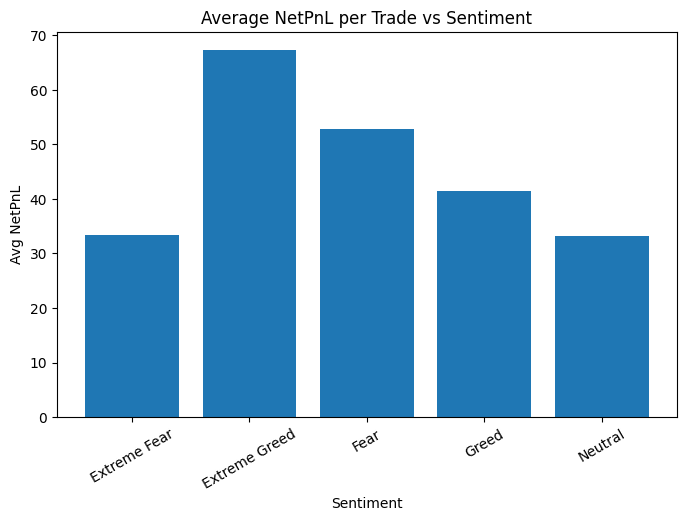

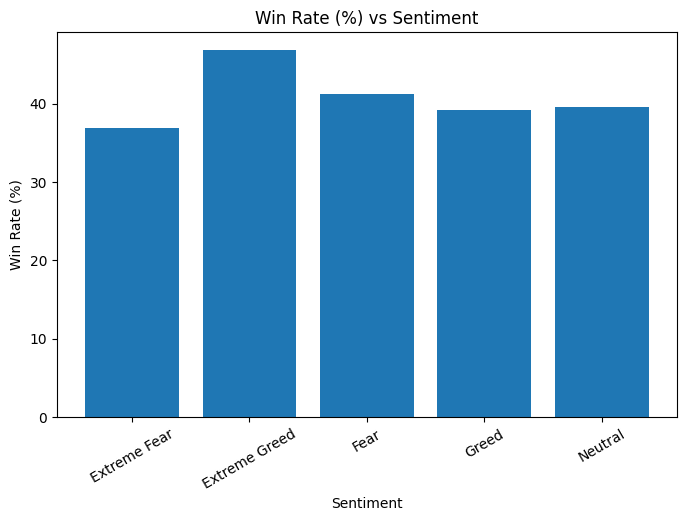

In [ ]:
import matplotlib.pyplot as plt

# Avg NetPnL graph
plt.figure(figsize=(8,5))
plt.bar(summary['classification'], summary['avg_netpnl'])
plt.title("Average NetPnL per Trade vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg NetPnL")
plt.xticks(rotation=30)
plt.show()

# Win rate graph
plt.figure(figsize=(8,5))
plt.bar(summary['classification'], summary['win_rate'])
plt.title("Win Rate (%) vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=30)
plt.show()


In [ ]:
side_summary = merged.groupby(['classification','Side']).size().reset_index(name='count')
print(side_summary)


  classification  Side  count
0   Extreme Fear   BUY  10935
1   Extreme Fear  SELL  10465
2  Extreme Greed   BUY  17940
3  Extreme Greed  SELL  22052
4           Fear   BUY  30270
5           Fear  SELL  31567
6          Greed   BUY  24576
7          Greed  SELL  25727
8        Neutral   BUY  18969
9        Neutral  SELL  18717


In [ ]:
side_pct = side_summary.copy()

side_pct['pct'] = (
    side_pct['count'] /
    side_pct.groupby('classification')['count'].transform('sum')
) * 100

print(side_pct)


  classification  Side  count        pct
0   Extreme Fear   BUY  10935  51.098131
1   Extreme Fear  SELL  10465  48.901869
2  Extreme Greed   BUY  17940  44.858972
3  Extreme Greed  SELL  22052  55.141028
4           Fear   BUY  30270  48.951275
5           Fear  SELL  31567  51.048725
6          Greed   BUY  24576  48.855933
7          Greed  SELL  25727  51.144067
8        Neutral   BUY  18969  50.334342
9        Neutral  SELL  18717  49.665658


Side              BUY   SELL
classification              
Extreme Fear    51.10  48.90
Extreme Greed   44.86  55.14
Fear            48.95  51.05
Greed           48.86  51.14
Neutral         50.33  49.67


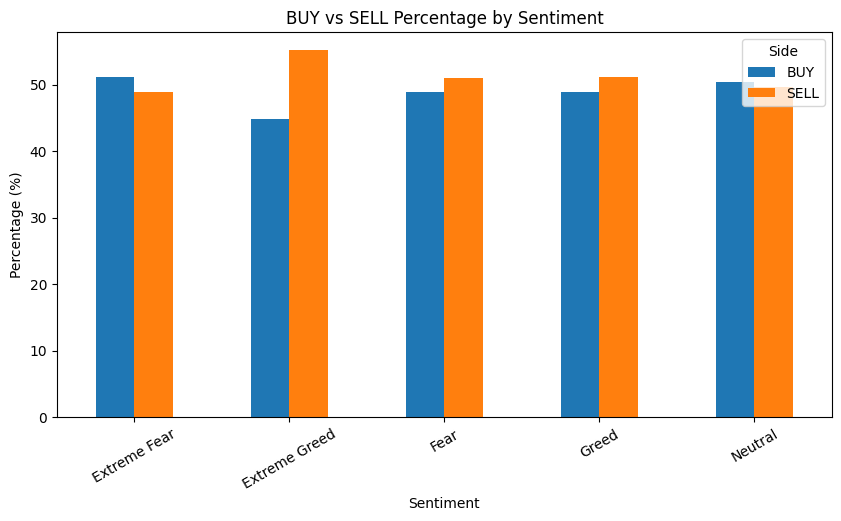

In [ ]:
import matplotlib.pyplot as plt

# % table
side_pct = side_summary.copy()
side_pct['pct'] = (side_pct['count'] / side_pct.groupby('classification')['count'].transform('sum')) * 100
side_pct['pct'] = side_pct['pct'].round(2)

# pivot for plotting
pivot_pct = side_pct.pivot(index='classification', columns='Side', values='pct')

print(pivot_pct)

# plot
pivot_pct.plot(kind='bar', figsize=(10,5))
plt.title("BUY vs SELL Percentage by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=30)
plt.show()
